<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/signal_kalman_nifty_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [37]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
pd.options.mode.chained_assignment = None

In [39]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftybanklist.csv')

In [40]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [41]:
nifty=yf.download('^nsei',start=START)

[*********************100%***********************]  1 of 1 completed


In [42]:
lst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  
  lst.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [43]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [44]:
df_kalman = pd.DataFrame(nlst).T

In [45]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [46]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [47]:
final_kalman=macd_calc(df_kalman)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragme

In [48]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,...,histkalman_47,macdkalman_48,macdsignalkalman_48,histkalman_48,macdkalman_49,macdsignalkalman_49,histkalman_49,macdkalman_50,macdsignalkalman_50,histkalman_50
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-11,135.071076,92.17019,53.345072,223.490759,535.413739,1069.837703,5.049211,83.713179,-163.571400,94.040617,...,-6.221865,8.000135,0.122204,7.877930,-87.584757,-191.548043,103.963286,-4.800066,-8.444386,3.644321
2022-04-12,124.173157,62.73960,65.090925,146.914397,468.554802,801.977920,-2.673916,66.643441,-168.428477,94.837489,...,-7.218470,8.508074,1.004928,7.503147,-75.479630,-179.330315,103.850685,-5.629736,-8.148107,2.518371


In [49]:
features = final_kalman.columns.tolist()

In [50]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [51]:
final_dataframe=final_kalman[feats_set1]

In [52]:
solution=np.sign(final_dataframe)

In [53]:
solution['final']=solution.sum(axis=1)

In [54]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,...,histkalman_42,histkalman_43,histkalman_44,histkalman_45,histkalman_46,histkalman_47,histkalman_48,histkalman_49,histkalman_50,final
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,40.0
2022-04-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,38.0


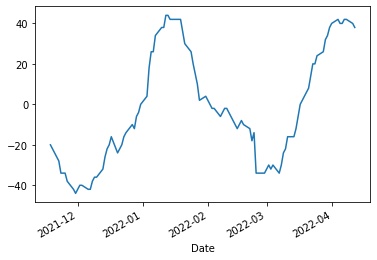

In [55]:
solution.final[-100:].plot()

In [56]:
solution['avg_mov']=solution['final'].rolling(window=10).mean()
nifty['avg_mov']=nifty['Adj Close'].rolling(window=22).mean()

In [57]:
l=1400

In [58]:
nifty=nifty[-l:]
solution=solution[-l:]

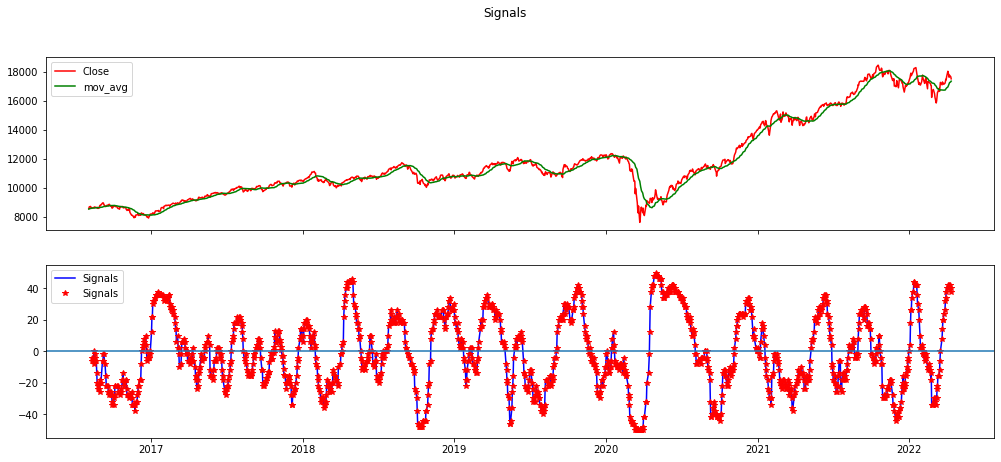

In [59]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'avg_mov'],'g', label='mov_avg')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

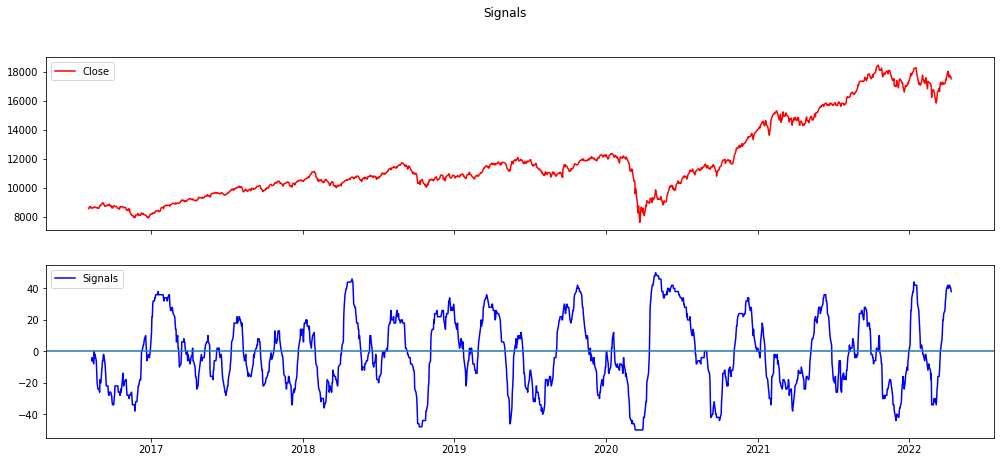

In [60]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'b', label='Signals')
#ax[1].plot(solution.iloc[:, :].index, solution.loc[:, 'avg_mov'], label='Moving_Average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [61]:
l=400

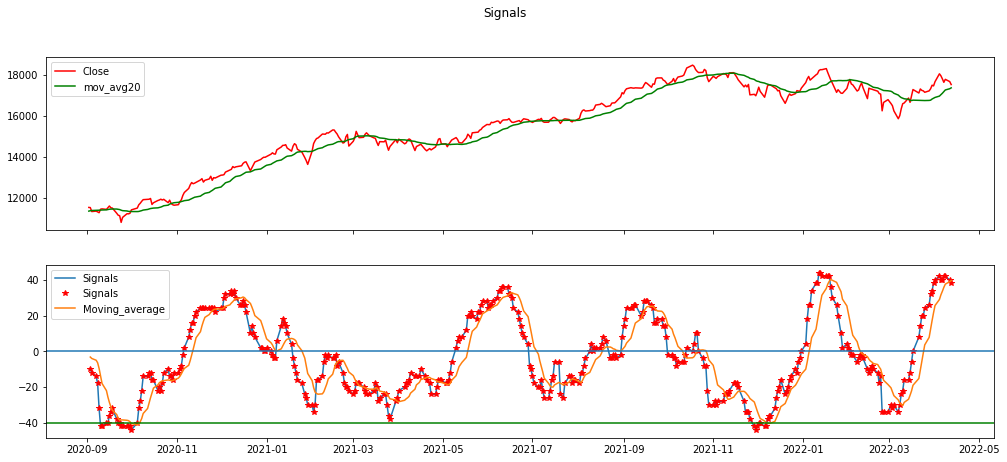

In [62]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='mov_avg20')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov'][-l:], label='Moving_average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

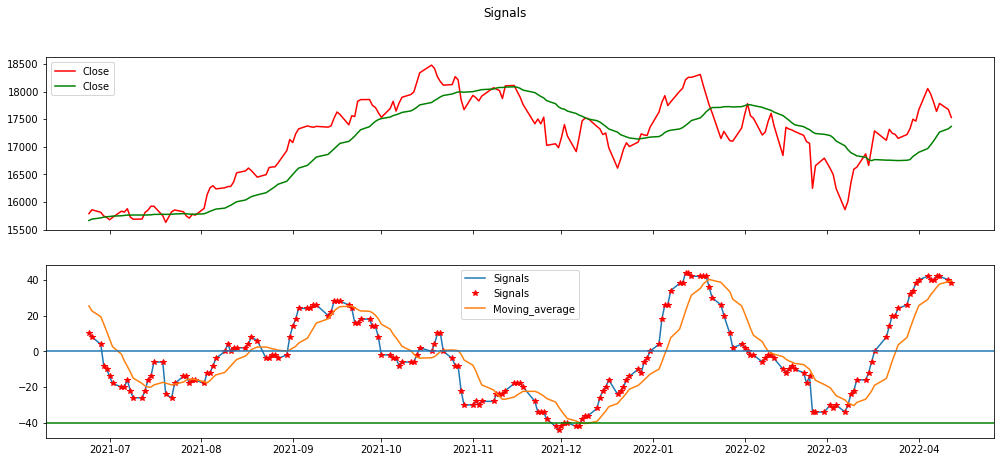

In [63]:
l=200
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'Close'][-l:],'r', label='Close')
ax[0].plot(nifty.loc[:, :].index[-l:], nifty.loc[:, 'avg_mov'][-l:],'g', label='Close')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:], label='Signals')
ax[1].plot(solution.loc[:, :].index[-l:], solution.loc[:, 'final'][-l:],'r*', label='Signals')
ax[1].plot(solution.iloc[:, :].index[-l:], solution.loc[:, 'avg_mov'][-l:], label='Moving_average')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
ax[1].axhline(y=-40,color='g')
plt.show()

In [64]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [65]:
if solution['signals'].iloc[-1]!=solution['signals'].iloc[-2]:
  var= solution['signals'].iloc[-1]
  print(f'signal changed to : {var}')
else :
  var= solution['signals'].iloc[-1]
  print(f'signal unchanged (1:stay long , -1: stay short) : {var}')

signal unchanged (1:stay long , -1: stay short) : 1


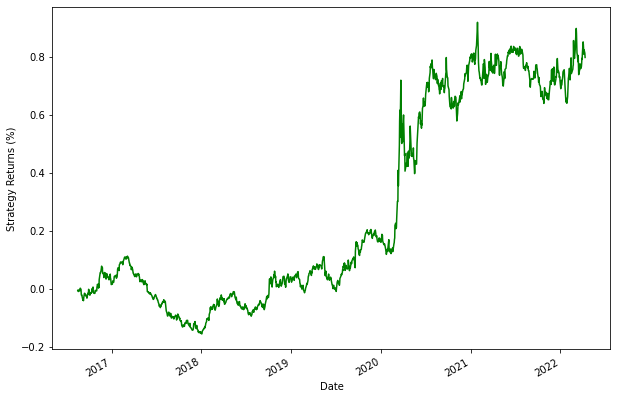

sharpe ratio :  0.04013017903221341
sortino ratio :  0.3351553016482557


In [66]:
# Calculate daily returns
nifty['Return'] = nifty.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * solution.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)

std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05)/std_neg
print('sortino ratio : ' , sortino_ratio)

In [67]:
def max_drawdown(return_series):
    comp_ret =return_series
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()
geometric_returns=pd.DataFrame(geometric_returns)

max_drawdowns= geometric_returns.apply(max_drawdown)
print('max_drawdown : ' , max_drawdowns)

max_drawdown :  Strategy_F   -20.12313
dtype: float64


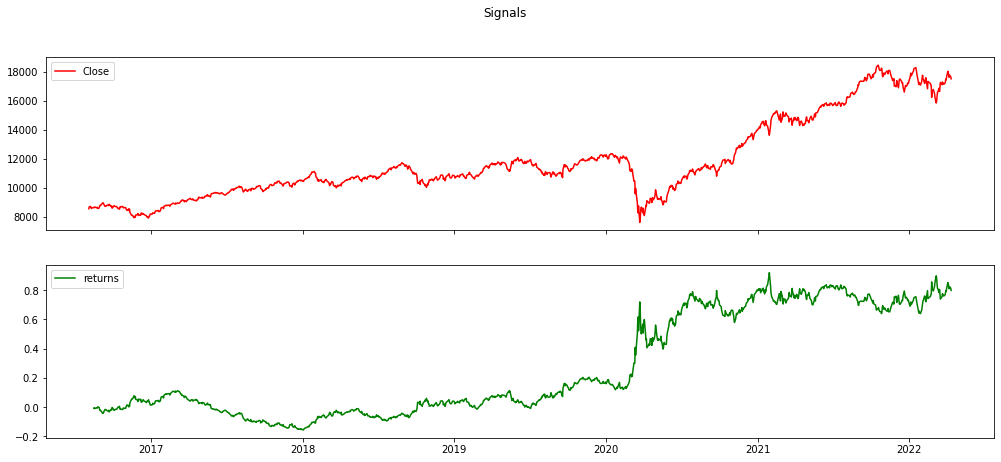

In [68]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'Close'],'r', label='Close')
ax[1].plot(geometric_returns.index,geometric_returns,'g', label='returns')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
plt.show()

In [69]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume,avg_mov,Return,Strategy_F
Date,,,,,,,,,
2022-04-11,17740.900391,17779.050781,17650.949219,17674.949219,17674.949219,251700,17326.118253,-0.006151,-0.006151
2022-04-12,17584.849609,17595.300781,17442.349609,17530.300781,17530.300781,0,17368.636452,-0.008184,-0.008184


In [70]:
print('change in nifty from yesterday' ,(nifty.Close.iloc[-1]-nifty.Close.iloc[-2])/nifty.Close.iloc[-2]*100)

change in nifty from yesterday -0.8183810641252284
